In [1]:
import sys
import time
import random
from os.path import exists
from typing import *

# Common data science imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.cluster import KMeans

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from tqdm import tqdm, notebook as tqdm_notebook

# GPyTorch and linear_operator imports
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.constraints import *
import linear_operator
from linear_operator.settings import max_cholesky_size
from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.utils.cholesky import psd_safe_cholesky

# Custom soft GP and MLL imports
from gp.soft_gp.soft_gp import SoftGP
from gp.soft_gp.mll import HutchinsonPseudoLoss
from linear_solver.cg import linear_cg

# Data analysis and UCI dataset

# Utility functions for dataset handling
from gp.util import flatten_dataset, split_dataset, filter_param

# Experiment tracking
import wandb

# System path adjustments
sys.path.append("../")

In [2]:
def eval_gp(model, test_dataset: Dataset, device="cuda:0") -> float:
    preds = []
    neg_mlls = []
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=1)
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds += [(model.pred(x_batch) - y_batch).detach().cpu()**2]
        neg_mlls += [-model.mll(x_batch, y_batch).detach().cpu()]
    rmse = torch.sqrt(torch.sum(torch.cat(preds)) / len(test_dataset)).item()
    neg_mll = torch.sum(torch.tensor(neg_mlls))
            
    print("RMSE:", rmse, "NEG_MLL", neg_mll.item(), "NOISE", model.noise.cpu().item(), "LENGTHSCALE", model.get_lengthscale(), "OUTPUTSCALE", model.get_outputscale())# "T",model.T)
    
    return {
        "rmse": rmse,
        "nll": neg_mll,
    }   
   

In [15]:
#==================Dataset============================
from data.get_uci import ElevatorsDataset,PoleteleDataset,ProteinDataset
# # dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/elevators/data.csv")
# dataset = PoleteleDataset("../data/uci_datasets/uci_datasets/pol/data.csv")
dataset = ProteinDataset("../data/uci_datasets/uci_datasets/protein/data.csv")
# dataset = CTSlicesDataset("../data/uci_datasets/uci_datasets/slice/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=9/10, #TODO change to real vals 
    val_frac=0/10
)

def plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs,  legend_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    epochs_range = range(1, epochs + 1)

    # Plot RMSE per Epoch for each model (baseline + CG tolerances)
    for i in range(len(legend_names)):
        label = legend_names[i]  # Use the provided names from legend_names list
        axes[0].plot(epochs_range, all_mean_rmse[i], label=label)
        
        # Fill between the RMSE values for standard deviation
        axes[0].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             [m + s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             alpha=0.3)

    axes[0].set_title('RMSE per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()

    # Plot Training Time per Epoch for each model (baseline + CG tolerances)
    for i in range(len(legend_names)):
        label = legend_names[i]  # Use the provided names from legend_names list
        axes[1].plot(epochs_range, all_mean_runtimes[i], label=label)
        
        # Fill between the runtime values for standard deviation
        axes[1].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             [m + s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             alpha=0.3)

    axes[1].set_title('Training Time per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Time (s)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def train_gp(GP_class, inducing_points, test_dataset, train_features, train_labels, epochs, device, dtype, model_config=None):
    model_config = model_config or {}
    kernel = RBFKernel().to(device=device, dtype=dtype)
    learn_noise = model_config.get("learn_noise", False)
    lr = model_config.get("learning_rate", 0.01)
    batch_size = model_config.get("batch_size", 1024)

    model = GP_class(
        kernel,
        inducing_points,
        noise=model_config.get("noise", 1e-3),
        learn_noise=learn_noise,
        use_scale=model_config.get("use_scale", True),
        dtype=dtype,
        max_cg_iter=1000,
        solver=model_config.get("solver", "solve"),
        mll_approx=model_config.get("mll_approx", "hutchinson"),
        fit_chunk_size=model_config.get("fit_chunk_size", 1024),
        use_qr=model_config.get("use_qr", True),
        hutch_solver = model_config.get("hutch_solver", "solve"),
    )


    epoch_runtimes = []
    epoch_rmse = []

    # pbar = tqdm(range(epochs), desc="Optimizing MLL")
    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    def train_model():
        #==================Train============================
        for _ in tqdm(range(epochs)):
            print("training current epoch")
            epoch_start_time = time.time()

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)), gpytorch.settings.max_preconditioner_size(15):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mll.backward()
                optimizer.step()
            model.fit(train_features, train_labels)
            epoch_end_time = time.time()
            epoch_runtimes.append(epoch_end_time - epoch_start_time)

            #==================Evaluate============================
            print("Running eval")
            eval_results = eval_gp(model, test_dataset, device=device)
            epoch_rmse.append(eval_results['rmse'])
            print("eval finished")    
    train_model()
    return epoch_rmse, epoch_runtimes

SIZE (45730, 10)


In [4]:
def benchmark(train_dataset, test_dataset, epochs=2, seed=42, N=3, configs=None):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_inducing = 512
    dtype = torch.float32
    device = "cpu"
    
    all_mean_rmse = []
    all_mean_runtimes = []
    all_std_rmse = []
    all_std_runtimes = []

    #==================Inducing Points============================
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)

    if configs is None:
        raise ValueError("You must provide a list of configurations in 'configs'")

    for config in configs:
        all_runs_rmse = []
        all_runs_runtimes = []

        solver_name = config.get("solver", "Unknown Solver")
        print(f"Running model with solver '{solver_name}'")

        for run in range(N):
            epoch_rmse, epoch_runtimes = train_gp(
                SoftGP,
                inducing_points.clone(),
                test_dataset,
                train_features,
                train_labels,
                epochs,
                device,
                dtype,
                model_config=config  # Pass current config
            )
            all_runs_rmse.append(epoch_rmse)
            all_runs_runtimes.append(epoch_runtimes)

        # Calculate mean and std deviation across the N runs for the current configuration
        mean_rmse = np.mean(all_runs_rmse, axis=0)
        std_rmse = np.std(all_runs_rmse, axis=0)
        mean_runtimes = np.mean(all_runs_runtimes, axis=0)
        std_runtimes = np.std(all_runs_runtimes, axis=0)

        all_mean_rmse.append(mean_rmse)
        all_mean_runtimes.append(mean_runtimes)
        all_std_rmse.append(std_rmse)
        all_std_runtimes.append(std_runtimes)

    return all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes

#==================Benchmark============================

# Example configurations
configs = [
    {"solver": "solve", "hutch_solver": "solve", "use_qr": True},  # Baseline
    {"solver": "solve", "hutch_solver": "cg","cg_tolerance": 1e-4,"use_qr": True},
    {"solver": "solve", "hutch_solver": "cholesky","use_qr": True},


    # {"solver": "cg", "cg_tolerance": 1e-8, "use_qr": True},
    # {"solver": "cg", "cg_tolerance": 0.5, "use_qr": True},
    # {"solver": "cg", "cg_tolerance": 1, "use_qr": True},
    # {"solver": "new_method", "parameter1": 0.1, "parameter2": True}  # Example for a new method
]



epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(train_dataset, test_dataset, epochs=epochs, seed=6535, N=N, configs=configs)

  0%|          | 0/2 [00:00<?, ?it/s]

Running model with solver 'solve'
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:02,  7.39s/it]

RMSE: 0.26628002524375916 NEG_MLL -1381.378662109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6324]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7648, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:14<05:57,  7.44s/it]

RMSE: 0.2484237402677536 NEG_MLL -1348.504638671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6104]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8378, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:48,  7.41s/it]

RMSE: 0.24112030863761902 NEG_MLL -1287.6817626953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6166]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9125, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:29<05:40,  7.40s/it]

RMSE: 0.23658813536167145 NEG_MLL -1214.3310546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6360]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9878, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:33,  7.40s/it]

RMSE: 0.231720432639122 NEG_MLL -1140.8406982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6572]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0651, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:44<05:26,  7.41s/it]

RMSE: 0.22845293581485748 NEG_MLL -1075.5628662109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6758]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1427, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:51<05:18,  7.41s/it]

RMSE: 0.22637152671813965 NEG_MLL -1015.4796142578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6889]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2213, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:59<05:14,  7.48s/it]

RMSE: 0.22378075122833252 NEG_MLL -966.1596069335938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6907]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2991, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:07<05:07,  7.51s/it]

RMSE: 0.22178839147090912 NEG_MLL -928.568603515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6861]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3787, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:14<04:59,  7.49s/it]

RMSE: 0.22019444406032562 NEG_MLL -893.1472778320312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6855]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4583, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:21<04:51,  7.47s/it]

RMSE: 0.21711745858192444 NEG_MLL -865.16064453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6825]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5360, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:29<04:43,  7.46s/it]

RMSE: 0.2153853178024292 NEG_MLL -835.7367553710938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6792]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6141, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:36<04:35,  7.45s/it]

RMSE: 0.21402153372764587 NEG_MLL -806.78955078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6764]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6915, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:44<04:28,  7.45s/it]

RMSE: 0.2130138874053955 NEG_MLL -782.40185546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6738]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7698, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:51<04:20,  7.45s/it]

RMSE: 0.21192562580108643 NEG_MLL -752.5487060546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6702]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8468, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:59<04:13,  7.45s/it]

RMSE: 0.21003776788711548 NEG_MLL -731.7614135742188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6565]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9245, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:06<04:05,  7.44s/it]

RMSE: 0.20928965508937836 NEG_MLL -717.0380859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6470]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9999, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:13<03:57,  7.43s/it]

RMSE: 0.2086769938468933 NEG_MLL -699.252197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6361]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0762, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:21<03:50,  7.45s/it]

RMSE: 0.2068466991186142 NEG_MLL -678.4139404296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6338]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1512, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:28<03:43,  7.44s/it]

RMSE: 0.2065613716840744 NEG_MLL -665.040283203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6263]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2253, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:36<03:35,  7.43s/it]

RMSE: 0.2056102603673935 NEG_MLL -646.7817993164062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6166]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2994, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:43<03:28,  7.43s/it]

RMSE: 0.20488670468330383 NEG_MLL -633.656005859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6137]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3730, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:51<03:20,  7.43s/it]

RMSE: 0.20386002957820892 NEG_MLL -623.5180053710938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6069]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4453, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [02:58<03:13,  7.43s/it]

RMSE: 0.20428848266601562 NEG_MLL -612.0348510742188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6008]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5162, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:06<03:06,  7.44s/it]

RMSE: 0.2029794603586197 NEG_MLL -600.5261840820312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5947]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5871, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:13<02:58,  7.44s/it]

RMSE: 0.20275095105171204 NEG_MLL -589.1947631835938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5842]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6570, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:20<02:50,  7.42s/it]

RMSE: 0.20288191735744476 NEG_MLL -578.5117797851562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5773]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7270, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:28<02:43,  7.41s/it]

RMSE: 0.20082111656665802 NEG_MLL -570.7003173828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5677]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7965, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:35<02:35,  7.40s/it]

RMSE: 0.2013164609670639 NEG_MLL -565.8587646484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5599]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8653, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:43<02:29,  7.47s/it]

RMSE: 0.20046348869800568 NEG_MLL -553.402587890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5518]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9335, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:50<02:22,  7.48s/it]

RMSE: 0.2004106342792511 NEG_MLL -548.5628051757812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5411]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0022, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [03:58<02:14,  7.49s/it]

RMSE: 0.20018668472766876 NEG_MLL -539.9775390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5350]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0697, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:05<02:06,  7.47s/it]

RMSE: 0.19914723932743073 NEG_MLL -531.1806640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5302]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1361, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:13<01:59,  7.47s/it]

RMSE: 0.1991177499294281 NEG_MLL -524.1260375976562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5234]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2013, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:20<01:51,  7.46s/it]

RMSE: 0.19849823415279388 NEG_MLL -517.0110473632812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5148]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2655, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:28<01:44,  7.45s/it]

RMSE: 0.1977066695690155 NEG_MLL -508.59881591796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5026]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3309, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:35<01:36,  7.45s/it]

RMSE: 0.19808043539524078 NEG_MLL -499.1071472167969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4921]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3979, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:42<01:29,  7.44s/it]

RMSE: 0.19882917404174805 NEG_MLL -491.6463317871094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4815]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4640, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:50<01:21,  7.44s/it]

RMSE: 0.19847974181175232 NEG_MLL -487.646728515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4721]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5278, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [04:57<01:14,  7.44s/it]

RMSE: 0.19814397394657135 NEG_MLL -480.6529541015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4619]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5900, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:05<01:06,  7.44s/it]

RMSE: 0.19719821214675903 NEG_MLL -475.2086486816406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4524]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6522, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:12<00:59,  7.46s/it]

RMSE: 0.1970294862985611 NEG_MLL -471.9388427734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4428]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7130, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:20<00:52,  7.46s/it]

RMSE: 0.19706036150455475 NEG_MLL -465.5955505371094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4336]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7737, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:27<00:44,  7.46s/it]

RMSE: 0.19822043180465698 NEG_MLL -461.133056640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4250]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8351, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:35<00:37,  7.46s/it]

RMSE: 0.1967633217573166 NEG_MLL -453.8616638183594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4170]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8952, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:42<00:29,  7.47s/it]

RMSE: 0.19695933163166046 NEG_MLL -448.8029479980469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4101]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9550, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:50<00:22,  7.45s/it]

RMSE: 0.19712930917739868 NEG_MLL -443.61065673828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4041]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0149, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [05:57<00:14,  7.47s/it]

RMSE: 0.19628632068634033 NEG_MLL -439.9079284667969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3991]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0737, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:04<00:07,  7.44s/it]

RMSE: 0.1963629573583603 NEG_MLL -433.40753173828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3941]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.1332, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:12<00:00,  7.45s/it]


RMSE: 0.1967267096042633 NEG_MLL -428.1112365722656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3892]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.1931, grad_fn=<SoftplusBackward0>)
eval finished
Running model with solver 'solve'
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:06,  7.47s/it]

RMSE: 0.2665790617465973 NEG_MLL -1379.379638671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6330]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7654, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:14<05:57,  7.45s/it]

RMSE: 0.25122159719467163 NEG_MLL -1339.365966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6139]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8389, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:49,  7.44s/it]

RMSE: 0.24231064319610596 NEG_MLL -1267.7720947265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6192]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9139, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:29<05:42,  7.44s/it]

RMSE: 0.23565031588077545 NEG_MLL -1204.269775390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6293]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9900, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:37<05:35,  7.45s/it]

RMSE: 0.23136065900325775 NEG_MLL -1139.7442626953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6398]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0671, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:44<05:27,  7.45s/it]

RMSE: 0.2281719297170639 NEG_MLL -1080.4906005859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6526]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1463, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:52<05:20,  7.45s/it]

RMSE: 0.22447708249092102 NEG_MLL -1022.5054321289062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6635]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2256, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:59<05:12,  7.44s/it]

RMSE: 0.22032088041305542 NEG_MLL -970.3216552734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6689]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3048, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:07<05:08,  7.51s/it]

RMSE: 0.2184656262397766 NEG_MLL -929.12744140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6698]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3843, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:15<05:03,  7.59s/it]

RMSE: 0.21671196818351746 NEG_MLL -892.5377807617188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6698]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4631, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:22<04:55,  7.58s/it]

RMSE: 0.21430230140686035 NEG_MLL -853.6377563476562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6723]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5403, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:30<04:48,  7.58s/it]

RMSE: 0.21380798518657684 NEG_MLL -823.8695068359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6712]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6181, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:37<04:39,  7.57s/it]

RMSE: 0.21295365691184998 NEG_MLL -798.9962768554688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6663]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6950, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:45<04:32,  7.58s/it]

RMSE: 0.2114962637424469 NEG_MLL -776.683349609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6595]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7720, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:52<04:25,  7.57s/it]

RMSE: 0.21000167727470398 NEG_MLL -757.0213623046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6432]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8510, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [02:00<04:17,  7.59s/it]

RMSE: 0.20893749594688416 NEG_MLL -734.0086059570312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6372]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9297, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:08<04:10,  7.58s/it]

RMSE: 0.20817221701145172 NEG_MLL -716.465087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6354]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0063, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:15<04:02,  7.59s/it]

RMSE: 0.20707790553569794 NEG_MLL -694.1241455078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6327]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0818, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:23<03:55,  7.59s/it]

RMSE: 0.20509576797485352 NEG_MLL -678.39697265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6240]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1558, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:30<03:46,  7.57s/it]

RMSE: 0.2062409222126007 NEG_MLL -665.8365478515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6140]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2313, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:38<03:39,  7.58s/it]

RMSE: 0.20666062831878662 NEG_MLL -651.8226318359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6079]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3068, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:45<03:32,  7.58s/it]

RMSE: 0.2032037228345871 NEG_MLL -632.934326171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6015]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3807, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:53<03:24,  7.59s/it]

RMSE: 0.20309852063655853 NEG_MLL -619.827392578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5937]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4525, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [03:01<03:17,  7.58s/it]

RMSE: 0.20291441679000854 NEG_MLL -612.6458740234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5866]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5245, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:08<03:10,  7.60s/it]

RMSE: 0.2021448314189911 NEG_MLL -606.2547607421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5784]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5951, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:16<03:03,  7.63s/it]

RMSE: 0.20240990817546844 NEG_MLL -591.9254150390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5669]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6660, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:24<02:55,  7.64s/it]

RMSE: 0.20274315774440765 NEG_MLL -584.5552368164062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5586]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7367, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:31<02:47,  7.63s/it]

RMSE: 0.20146456360816956 NEG_MLL -570.810791015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5481]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8071, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:39<02:40,  7.63s/it]

RMSE: 0.20074118673801422 NEG_MLL -561.6561279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5431]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8757, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:46<02:31,  7.58s/it]

RMSE: 0.20024725794792175 NEG_MLL -556.1287841796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5363]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9435, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:54<02:23,  7.57s/it]

RMSE: 0.1982210874557495 NEG_MLL -547.338134765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5246]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0106, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [04:02<02:17,  7.62s/it]

RMSE: 0.1988641619682312 NEG_MLL -539.711181640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5165]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0768, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:09<02:09,  7.63s/it]

RMSE: 0.1996547132730484 NEG_MLL -529.8380737304688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5079]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1434, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:17<02:02,  7.63s/it]

RMSE: 0.20006534457206726 NEG_MLL -523.8720092773438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4995]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2100, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:25<01:54,  7.64s/it]

RMSE: 0.19881609082221985 NEG_MLL -515.0308227539062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4935]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2761, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:32<01:46,  7.62s/it]

RMSE: 0.1979077011346817 NEG_MLL -507.198486328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4855]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3412, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:40<01:39,  7.64s/it]

RMSE: 0.19711989164352417 NEG_MLL -502.9230651855469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4772]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4059, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:47<01:31,  7.62s/it]

RMSE: 0.19788876175880432 NEG_MLL -493.53155517578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4709]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4711, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:55<01:23,  7.62s/it]

RMSE: 0.19641900062561035 NEG_MLL -485.3721923828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4629]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5364, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [05:03<01:16,  7.64s/it]

RMSE: 0.19760724902153015 NEG_MLL -480.6771240234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4541]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5998, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:10<01:08,  7.66s/it]

RMSE: 0.19686433672904968 NEG_MLL -475.9524841308594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4471]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6612, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:18<01:01,  7.65s/it]

RMSE: 0.19615542888641357 NEG_MLL -468.3621520996094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4387]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7232, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:26<00:53,  7.63s/it]

RMSE: 0.19796963036060333 NEG_MLL -463.32550048828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4307]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7840, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:33<00:45,  7.61s/it]

RMSE: 0.1967213749885559 NEG_MLL -459.432373046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4241]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8452, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:41<00:38,  7.62s/it]

RMSE: 0.19527682662010193 NEG_MLL -450.0340270996094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4182]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9061, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:48<00:30,  7.64s/it]

RMSE: 0.1973142772912979 NEG_MLL -447.5882568359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4101]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9670, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:56<00:22,  7.66s/it]

RMSE: 0.19596543908119202 NEG_MLL -440.717041015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4029]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0265, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [06:04<00:15,  7.68s/it]

RMSE: 0.19530408084392548 NEG_MLL -437.3667297363281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3965]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0850, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:12<00:07,  7.68s/it]

RMSE: 0.19577471911907196 NEG_MLL -433.7666320800781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3897]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.1438, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:19<00:00,  7.60s/it]


RMSE: 0.19529801607131958 NEG_MLL -426.302734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3843]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.2021, grad_fn=<SoftplusBackward0>)
eval finished
Running model with solver 'solve'
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:07<06:12,  7.59s/it]

RMSE: 0.2662927210330963 NEG_MLL -1366.9066162109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6309]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.7647, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:15<06:07,  7.65s/it]

RMSE: 0.2502092719078064 NEG_MLL -1339.4986572265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6048]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.8362, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:22<05:59,  7.64s/it]

RMSE: 0.24133595824241638 NEG_MLL -1278.6031494140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6089]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9099, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:30<05:51,  7.65s/it]

RMSE: 0.23670043051242828 NEG_MLL -1214.0897216796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6218]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(0.9859, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:38<05:43,  7.63s/it]

RMSE: 0.23220348358154297 NEG_MLL -1149.1695556640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6362]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.0624, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:46<05:41,  7.75s/it]

RMSE: 0.22809113562107086 NEG_MLL -1089.9803466796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6512]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.1394, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:53<05:30,  7.69s/it]

RMSE: 0.22551229596138 NEG_MLL -1040.314453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6609]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2169, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [01:01<05:21,  7.64s/it]

RMSE: 0.22312551736831665 NEG_MLL -984.9475708007812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6704]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.2952, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [01:08<05:13,  7.66s/it]

RMSE: 0.22165432572364807 NEG_MLL -944.584716796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6738]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.3742, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [01:16<05:05,  7.63s/it]

RMSE: 0.22166039049625397 NEG_MLL -911.09716796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6690]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.4527, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [01:24<04:57,  7.64s/it]

RMSE: 0.21975751221179962 NEG_MLL -878.7596435546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6661]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.5311, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [01:32<04:53,  7.72s/it]

RMSE: 0.2169973999261856 NEG_MLL -849.8675537109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6608]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6093, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [01:39<04:44,  7.69s/it]

RMSE: 0.21457509696483612 NEG_MLL -822.7808837890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6535]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.6879, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:47<04:35,  7.67s/it]

RMSE: 0.21409428119659424 NEG_MLL -794.35888671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6462]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.7656, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:55<04:29,  7.69s/it]

RMSE: 0.2121230959892273 NEG_MLL -773.3514404296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6399]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.8417, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [02:02<04:21,  7.70s/it]

RMSE: 0.2124086618423462 NEG_MLL -748.9988403320312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6344]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9189, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [02:10<04:13,  7.67s/it]

RMSE: 0.21072392165660858 NEG_MLL -729.51025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6282]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(1.9970, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [02:18<04:05,  7.67s/it]

RMSE: 0.20992888510227203 NEG_MLL -710.3603515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6253]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.0738, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [02:25<03:56,  7.63s/it]

RMSE: 0.20872381329536438 NEG_MLL -692.54833984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6173]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.1510, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [02:33<03:48,  7.61s/it]

RMSE: 0.20752985775470734 NEG_MLL -678.6741333007812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.6085]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2238, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [02:40<03:40,  7.61s/it]

RMSE: 0.20647411048412323 NEG_MLL -663.5381469726562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5976]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.2970, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [02:48<03:34,  7.65s/it]

RMSE: 0.2057240903377533 NEG_MLL -651.0560913085938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5854]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.3699, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [02:56<03:26,  7.66s/it]

RMSE: 0.20522703230381012 NEG_MLL -639.4397583007812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5761]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.4425, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [03:03<03:19,  7.67s/it]

RMSE: 0.20472337305545807 NEG_MLL -629.1849975585938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5638]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5152, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [03:11<03:11,  7.68s/it]

RMSE: 0.20387184619903564 NEG_MLL -617.169677734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5549]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.5877, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [03:19<03:04,  7.70s/it]

RMSE: 0.20283745229244232 NEG_MLL -602.7523803710938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5439]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.6601, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [03:26<02:55,  7.65s/it]

RMSE: 0.20313343405723572 NEG_MLL -591.8026733398438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5334]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7293, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [03:34<02:47,  7.64s/it]

RMSE: 0.20255237817764282 NEG_MLL -580.711669921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5231]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.7983, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [03:42<02:40,  7.62s/it]

RMSE: 0.20073768496513367 NEG_MLL -573.9274291992188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5113]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.8693, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [03:49<02:32,  7.63s/it]

RMSE: 0.20126649737358093 NEG_MLL -568.4937744140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.5014]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(2.9387, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [03:57<02:24,  7.60s/it]

RMSE: 0.19940190017223358 NEG_MLL -555.6874389648438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4909]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0082, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [04:04<02:16,  7.58s/it]

RMSE: 0.19916477799415588 NEG_MLL -545.899169921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4811]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.0769, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [04:12<02:09,  7.60s/it]

RMSE: 0.1990291178226471 NEG_MLL -539.05078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4706]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.1441, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [04:19<02:01,  7.60s/it]

RMSE: 0.19962047040462494 NEG_MLL -532.3518676757812 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4610]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2120, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [04:27<01:53,  7.59s/it]

RMSE: 0.19943132996559143 NEG_MLL -522.7546997070312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4523]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.2778, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [04:35<01:46,  7.57s/it]

RMSE: 0.19930054247379303 NEG_MLL -513.39306640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4457]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.3415, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [04:42<01:38,  7.59s/it]

RMSE: 0.19877126812934875 NEG_MLL -508.1392517089844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4376]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4050, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [04:50<01:31,  7.63s/it]

RMSE: 0.19907018542289734 NEG_MLL -502.8763427734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4273]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.4697, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [04:58<01:24,  7.67s/it]

RMSE: 0.19902420043945312 NEG_MLL -493.2132873535156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4192]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5339, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [05:05<01:17,  7.70s/it]

RMSE: 0.19881366193294525 NEG_MLL -487.9801025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4106]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.5978, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [05:13<01:08,  7.66s/it]

RMSE: 0.19783563911914825 NEG_MLL -481.4885559082031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.4043]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.6600, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [05:21<01:01,  7.65s/it]

RMSE: 0.19718706607818604 NEG_MLL -475.3977355957031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3977]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7230, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [05:28<00:53,  7.69s/it]

RMSE: 0.1978737860918045 NEG_MLL -467.8042297363281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3916]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.7847, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [05:36<00:46,  7.69s/it]

RMSE: 0.19697792828083038 NEG_MLL -464.85992431640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3859]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.8445, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [05:44<00:38,  7.73s/it]

RMSE: 0.1965111792087555 NEG_MLL -459.43841552734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3802]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9036, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [05:52<00:31,  7.77s/it]

RMSE: 0.1966000497341156 NEG_MLL -453.14691162109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3755]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(3.9624, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [05:59<00:23,  7.71s/it]

RMSE: 0.19739508628845215 NEG_MLL -447.28240966796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3704]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0211, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [06:07<00:15,  7.67s/it]

RMSE: 0.19628827273845673 NEG_MLL -441.75299072265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3655]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.0810, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [06:14<00:07,  7.62s/it]

RMSE: 0.19708144664764404 NEG_MLL -437.66473388671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3609]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.1397, grad_fn=<SoftplusBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [06:22<00:00,  7.65s/it]

RMSE: 0.19836878776550293 NEG_MLL -433.65435791015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.3569]], grad_fn=<SoftplusBackward0>) OUTPUTSCALE tensor(4.1981, grad_fn=<SoftplusBackward0>)
eval finished


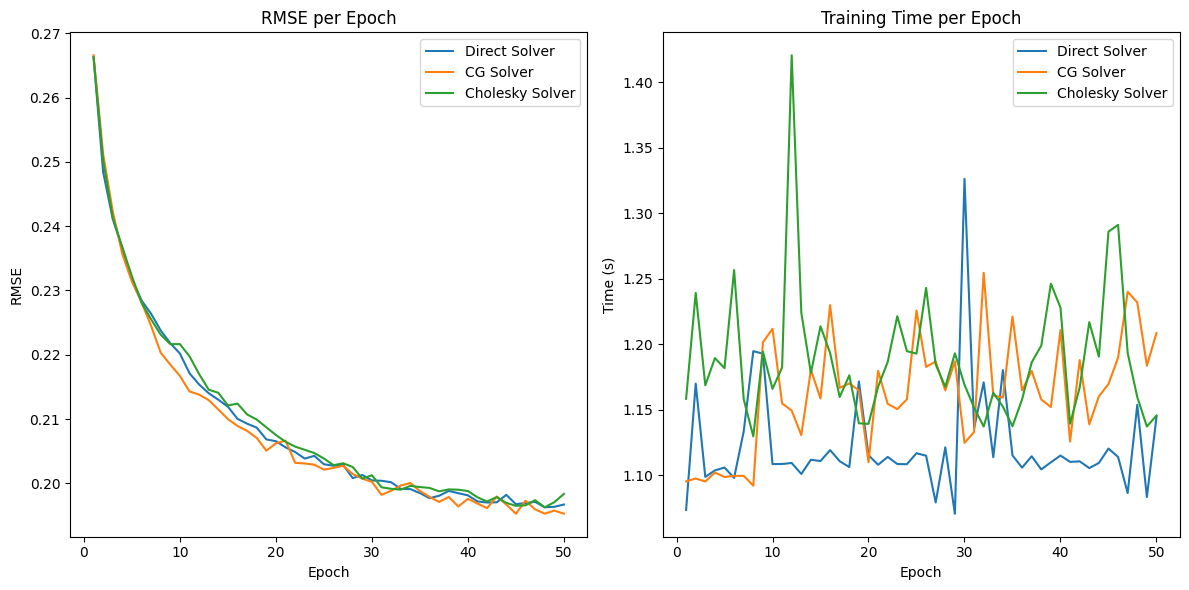

In [8]:
legend_names = ['Direct Solver', 'CG Solver', 'Cholesky Solver']
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, legend_names)

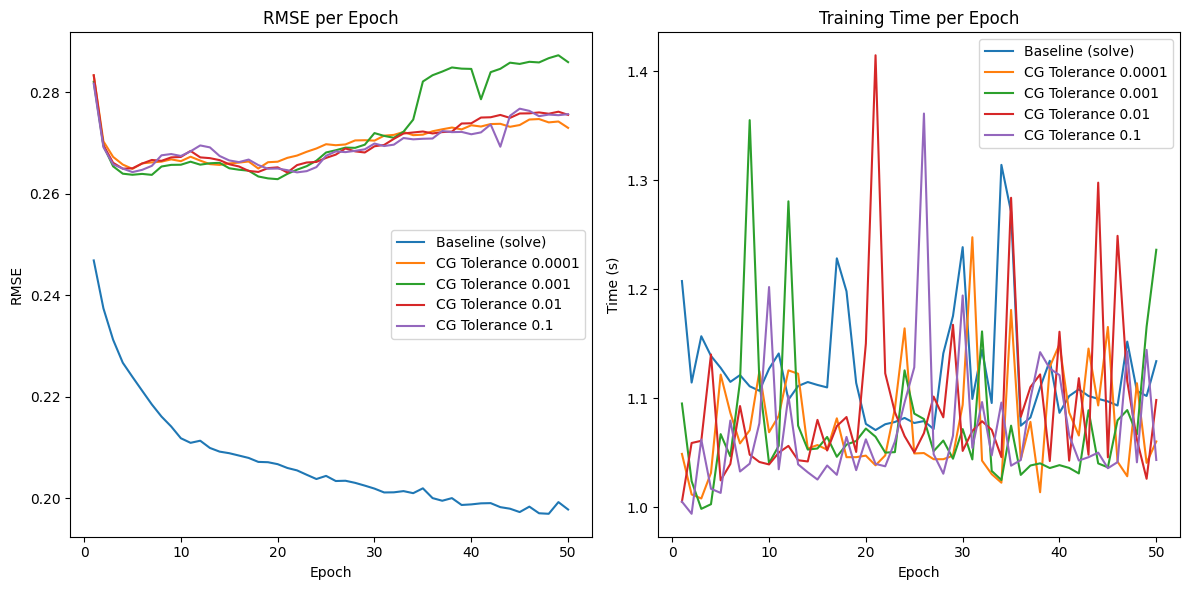

In [12]:
#max iter 50 CG hutch solve CG fit 
tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

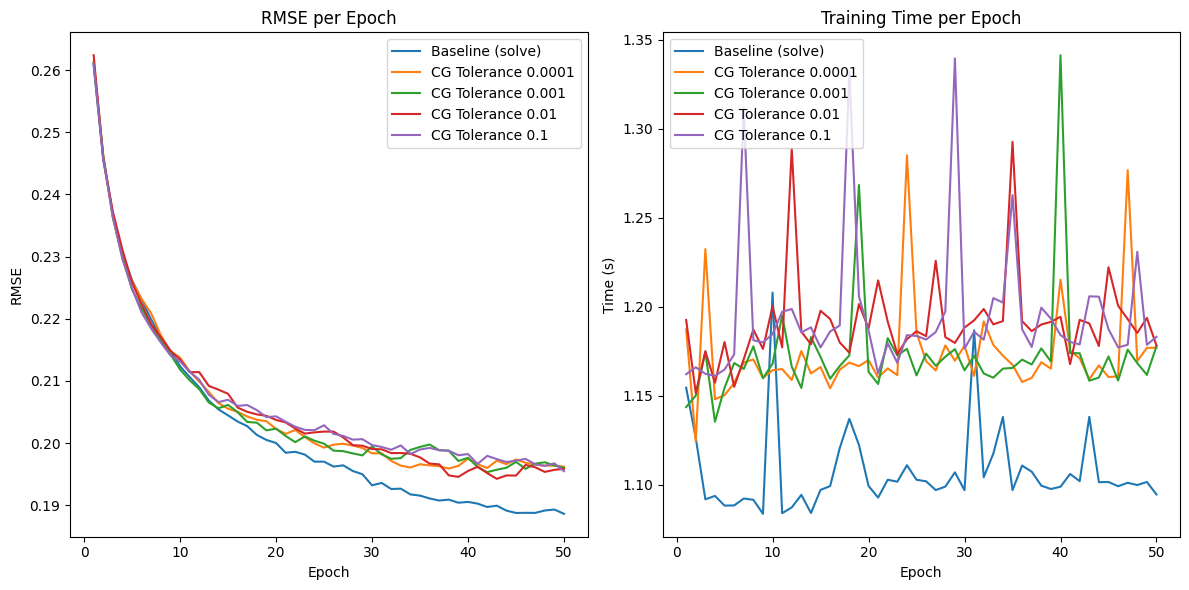

In [29]:
# #max iter 50 CG hutch QR fit
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
# plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

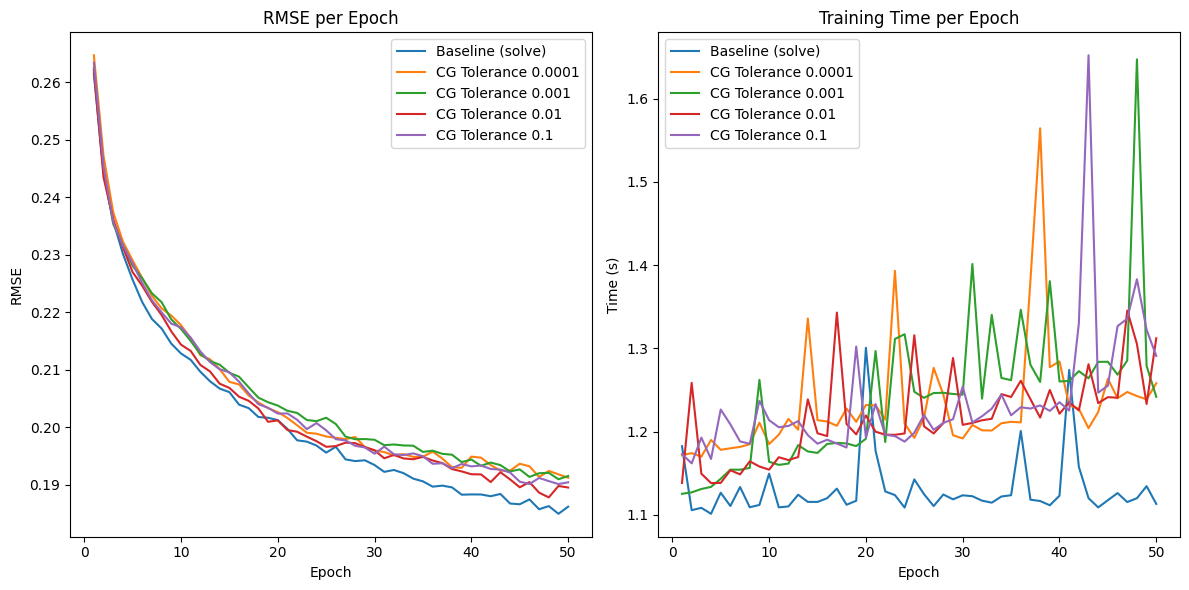

In [32]:
# #max iter 1000 CG hutch QR fit
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
# plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

### CG Fit Testing 


In [11]:

configs = [
    {"solver": "solve", "hutch_solver": "solve","cg_tolerance": 1e-4,"use_qr": True},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-4,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-3,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-2,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-1,"use_qr": False},
    {"solver": "cholesky", "hutch_solver": "solve","use_qr": False},
    {"solver": "solve", "hutch_solver": "solve","use_qr": False},
]
legend_names = ['QR Solve', 'CG Solver 1e-4','CG Solver 1e-3','CG Solver 1e-2','CG Solver 1e-1','Cholesky Solver',"Direct Solver"]

epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(train_dataset, test_dataset, epochs=epochs, seed=6535, N=N, configs=configs)

  0%|          | 0/2 [00:00<?, ?it/s]

Running model with solver 'solve'
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

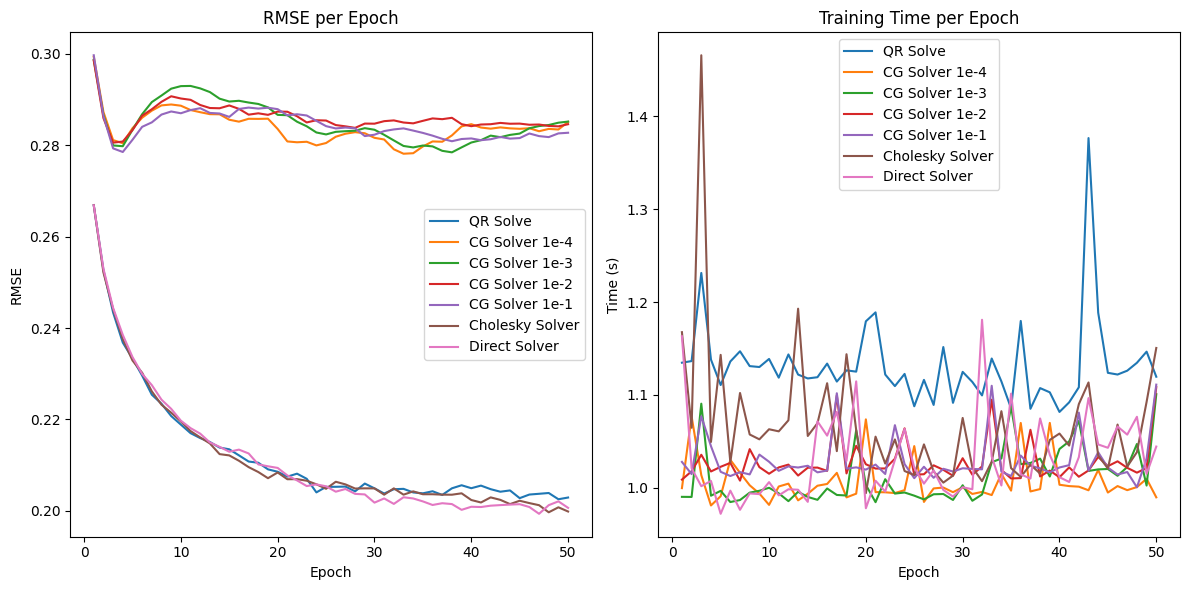

In [14]:
legend_names = ['QR Solve', 'CG Solver 1e-4','CG Solver 1e-3','CG Solver 1e-2','CG Solver 1e-1','Cholesky Solver',"Direct Solver"]
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, legend_names)